# Modules Import

In [2]:
#Import the modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras import metrics
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
import wandb
from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint



# Wandb init and config 

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="grapes-leaf",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 32,
        "activation_1": "relu",
        "layer_2": 64,
        "activation_2": "relu",
        "layer_3": 64,
        "activation_3": "relu",
        "layer_4": 64,
        "activation_4": "relu",
        "layer_5": 64,
        "activation_5": "relu",
        "layer_6": 64,
        "activation_6": "relu",
        "kernel_size": (3,3),
        "pool_size":(2,2),
        "n_dense_1": 64,
        "activation_ndense_1": "relu",
        "n_dense_2": 4,
        "activation_ndense_2": "softmax",
        "image_size": 256,
        "optimizer": "adam",
        "loss": "sparse_categorical_crossentropy",
        "metrics": "accuracy",
        "epochs": 36,
        "batch_size": 32,
        "steps_per_epoch": 92,
        "validation_steps": 22,
        "verbose": 1,
        "use_multiprocessing": True,
        "workers": 4
    }
)

wandb: Currently logged in as: adiazmazzola. Use `wandb login --relogin` to force relogin


In [4]:
config = wandb.config

# Data load, Read and Augmentation

In [5]:

testDf= tf.keras.utils.image_dataset_from_directory(
   "DataSets/deeplproj-grapes/test",
    labels='inferred',
    shuffle= True,
    batch_size= 32,
    image_size= (256,256)
)


Found 405 files belonging to 4 classes.


2024-01-07 18:09:40.295861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2475 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
class_names=testDf.class_names
class_names

['black rot',
 'esca (black measles)',
 'healthy',
 'leaf blight (isariopsis leaf spot)']

In [7]:
IMAGE_SIZE=256
CHANELS = 3

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True,
    rotation_range= 10,
    
)

train_generator = train_data_generator.flow_from_directory(
    'DataSets/deeplproj-grapes/train/',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 2927 images belonging to 4 classes.


In [8]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(32, 256, 256, 3)


In [9]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True,
    rotation_range= 10,
    
)

validation_generator = train_data_generator.flow_from_directory(
    'DataSets/deeplproj-grapes/validation/',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 730 images belonging to 4 classes.


In [10]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True,
    rotation_range= 10,
    
)

test_generator = train_data_generator.flow_from_directory(
    'DataSets/deeplproj-grapes/test/',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 405 images belonging to 4 classes.


# Now we start with the model

In [11]:
#Now we start wiht CNN use with the parameters configured on wandb for later reporting and colaboration
from tensorflow.keras.layers import Input
input_shape=(config.image_size,config.image_size,3)
n_classes = 4

model= models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(filters=config.layer_1,kernel_size=config.kernel_size, activation=config.activation_1),
    layers.MaxPooling2D(config.pool_size),
    layers.Conv2D(filters=config.layer_2,kernel_size=config.kernel_size ,activation=config.activation_2),
    layers.MaxPooling2D(config.pool_size),
    layers.Conv2D(filters=config.layer_3,kernel_size=config.kernel_size, activation=config.activation_3),
    layers.MaxPooling2D(config.pool_size),
    layers.Conv2D(filters=config.layer_4,kernel_size=config.kernel_size, activation=config.activation_4),
    layers.MaxPooling2D(config.pool_size),
    layers.Conv2D(filters=config.layer_5,kernel_size=config.kernel_size, activation=config.activation_5),
    layers.MaxPooling2D(config.pool_size),
    layers.Conv2D(filters=config.layer_6,kernel_size=config.kernel_size, activation=config.activation_6),
    layers.MaxPooling2D(config.pool_size),
    layers.Flatten(),
    layers.Dense(config.n_dense_1, activation= config.activation_ndense_1),
    layers.Dense(n_classes, activation=config.activation_ndense_2),
])

#model.build(input_shape=IMAGE_SIZE)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [13]:
#metrics = [Accuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [14]:
model.compile(
    optimizer= config.optimizer,
    loss= config.loss,
    metrics= [config.metrics], 
)

In [15]:
#steps per epoch training data / batch size
2927/32


91.46875

# Model training and register of artifacts through wandb, also monitoring

In [16]:

history = model.fit(
    train_generator,
    steps_per_epoch=config.steps_per_epoch,
    batch_size=config.batch_size,
    validation_data= validation_generator,
    validation_steps=config.validation_steps,
    verbose=config.verbose,
    epochs=config.epochs,
    use_multiprocessing=config.use_multiprocessing,
    workers=config.workers,
    callbacks=[WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models"),
               WandbCallback(
        validation_data=validation_generator,
        labels = class_names,
        monitor='accuracy',
        input_type= 'image',
        log_weights=(True),
        log_evaluation=(True),
        
    )]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/36


2024-01-07 18:10:09.108403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-07 18:10:10.170346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7da4d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 18:10:10.170407: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-01-07 18:10:10.180585: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-07 18:10:10.343540: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-07 18:10:11.813834: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller

92/92 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.4892INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 141ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 25s 210ms/step - loss: 1.0564 - accuracy: 0.4892 - val_loss: 0.6555 - val_accuracy: 0.7131
Epoch 2/36
92/92 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.7902INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 52ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 19s 196ms/step - loss: 0.5287 - accuracy: 0.7902 - val_loss: 0.3469 - val_accuracy: 0.8509
Epoch 3/36
92/92 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8685INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 61ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 19s 199ms/step - loss: 0.3330 - accuracy: 0.8685 - val_loss: 0.2758 - val_accuracy: 0.8906
Epoch 4/36
92/92 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.8992INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 50ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 20s 204ms/step - loss: 0.2558 - accuracy: 0.8992 - val_loss: 0.2147 - val_accuracy: 0.9134
Epoch 5/36
92/92 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9211INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 45ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.1s


92/92 [==============================] - 24s 256ms/step - loss: 0.2150 - accuracy: 0.9211 - val_loss: 0.2435 - val_accuracy: 0.9134
Epoch 6/36
92/92 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9375INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 50ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.1s


92/92 [==============================] - 24s 248ms/step - loss: 0.1660 - accuracy: 0.9375 - val_loss: 0.1084 - val_accuracy: 0.9645
Epoch 7/36
92/92 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9518INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 35ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 19s 197ms/step - loss: 0.1258 - accuracy: 0.9518 - val_loss: 0.0946 - val_accuracy: 0.9645
Epoch 8/36
92/92 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9583INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 57ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 216ms/step - loss: 0.1105 - accuracy: 0.9583 - val_loss: 0.0824 - val_accuracy: 0.9645
Epoch 9/36
92/92 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9645INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 52ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 20s 205ms/step - loss: 0.0973 - accuracy: 0.9645 - val_loss: 0.0650 - val_accuracy: 0.9759
Epoch 10/36
92/92 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9754INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 50ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 20s 203ms/step - loss: 0.0691 - accuracy: 0.9754 - val_loss: 0.0655 - val_accuracy: 0.9702
Epoch 11/36
92/92 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9679INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 24s 252ms/step - loss: 0.0966 - accuracy: 0.9679 - val_loss: 0.0490 - val_accuracy: 0.9801
Epoch 12/36
92/92 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9792INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 58ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 20s 209ms/step - loss: 0.0631 - accuracy: 0.9792 - val_loss: 0.0354 - val_accuracy: 0.9872
Epoch 13/36
92/92 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9836INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 40ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 218ms/step - loss: 0.0534 - accuracy: 0.9836 - val_loss: 0.0215 - val_accuracy: 0.9943
Epoch 14/36
92/92 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9918INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 39ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 215ms/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.0197 - val_accuracy: 0.9943
Epoch 15/36
92/92 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9945INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 35ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 218ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.0108 - val_accuracy: 0.9972
Epoch 16/36
92/92 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9768INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 197ms/step - loss: 0.0665 - accuracy: 0.9768 - val_loss: 0.0523 - val_accuracy: 0.9815
Epoch 17/36
92/92 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9880INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 198ms/step - loss: 0.0335 - accuracy: 0.9880 - val_loss: 0.0072 - val_accuracy: 0.9986
Epoch 18/36
92/92 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9781INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 200ms/step - loss: 0.0610 - accuracy: 0.9781 - val_loss: 0.0154 - val_accuracy: 0.9972
Epoch 19/36
92/92 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9850INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 201ms/step - loss: 0.0360 - accuracy: 0.9850 - val_loss: 0.0305 - val_accuracy: 0.9872
Epoch 20/36
92/92 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9870INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 24s 255ms/step - loss: 0.0326 - accuracy: 0.9870 - val_loss: 0.0086 - val_accuracy: 0.9986
Epoch 21/36
92/92 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9973INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 56ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 20s 211ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.0055 - val_accuracy: 0.9986
Epoch 22/36
92/92 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9969INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 25s 263ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.0088 - val_accuracy: 0.9972
Epoch 23/36
92/92 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9843INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 20s 207ms/step - loss: 0.0531 - accuracy: 0.9843 - val_loss: 0.0350 - val_accuracy: 0.9858
Epoch 24/36
92/92 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9959INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 198ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0117 - val_accuracy: 0.9957
Epoch 25/36
92/92 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9894INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 199ms/step - loss: 0.0302 - accuracy: 0.9894 - val_loss: 0.0236 - val_accuracy: 0.9886
Epoch 26/36
92/92 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9939INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 20s 210ms/step - loss: 0.0156 - accuracy: 0.9939 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 27/36
92/92 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9980INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 32ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 22s 225ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0366 - val_accuracy: 0.9886
Epoch 28/36
92/92 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9904INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 196ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0823 - val_accuracy: 0.9787
Epoch 29/36
92/92 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9894INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 20s 203ms/step - loss: 0.0305 - accuracy: 0.9894 - val_loss: 0.0482 - val_accuracy: 0.9844
Epoch 30/36
92/92 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9935INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 200ms/step - loss: 0.0180 - accuracy: 0.9935 - val_loss: 0.0039 - val_accuracy: 0.9986
Epoch 31/36
92/92 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9966INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 26s 268ms/step - loss: 0.0128 - accuracy: 0.9966 - val_loss: 0.0130 - val_accuracy: 0.9929
Epoch 32/36
92/92 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9959INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 19s 195ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0120 - val_accuracy: 0.9972
Epoch 33/36
92/92 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9980INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


92/92 [==============================] - 20s 208ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.0083 - val_accuracy: 0.9957
Epoch 34/36
92/92 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9986INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 38ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 220ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0023 - val_accuracy: 0.9986
Epoch 35/36
92/92 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 35ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 21s 220ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 36/36
92/92 [==============================] - ETA: 0s - loss: 6.4579e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1/1 [==============================] - 0s 39ms/step


/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets


INFO:tensorflow:Assets written to: /home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best/assets
wandb: Adding directory to artifact (/home/alvaro/Documents/JupyterLab1/DeepLearningProject/wandb/run-20240107_180919-icn4y2wq/files/model-best)... Done. 0.0s


92/92 [==============================] - 22s 225ms/step - loss: 6.4579e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000


In [17]:
scores = model.evaluate(test_generator)

13/13 [==============================] - 4s 317ms/step - loss: 6.1680e-04 - accuracy: 1.0000


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']


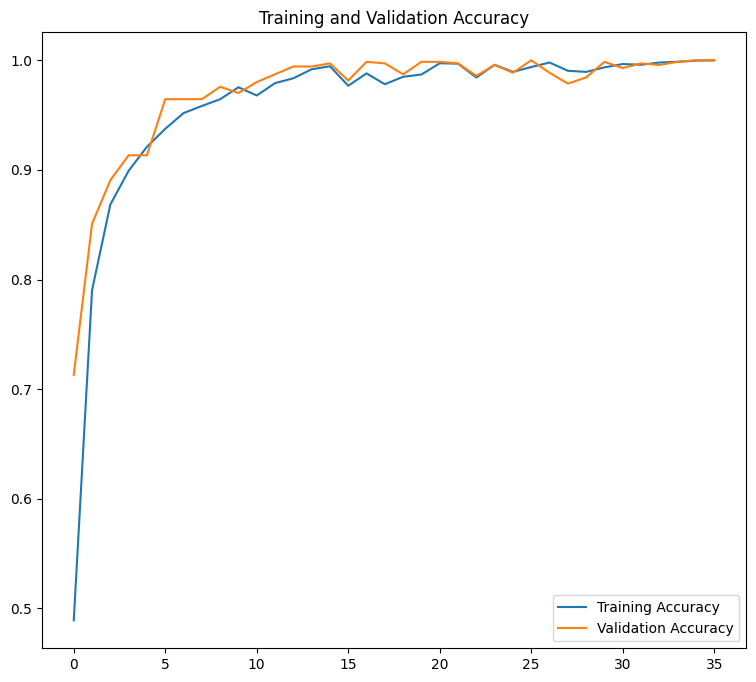

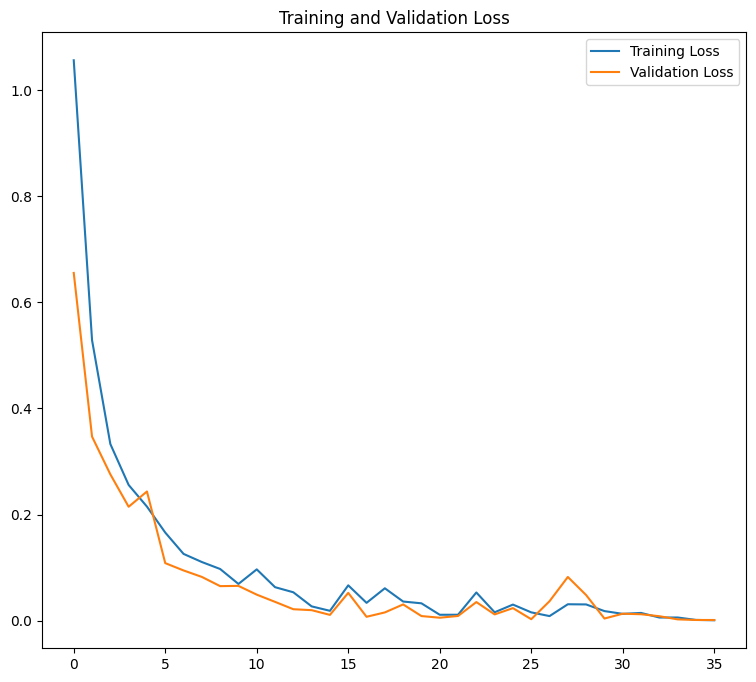

In [19]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(range(config.epochs), acc, label='Training Accuracy')
plt.plot(range(config.epochs), val_acc , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(range(config.epochs), loss, label='Training Loss')
plt.plot(range(config.epochs), val_loss , label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to predict
Actual label:  healthy
1/1 [==============================] - 0s 43ms/step
Predicted Label:  healthy


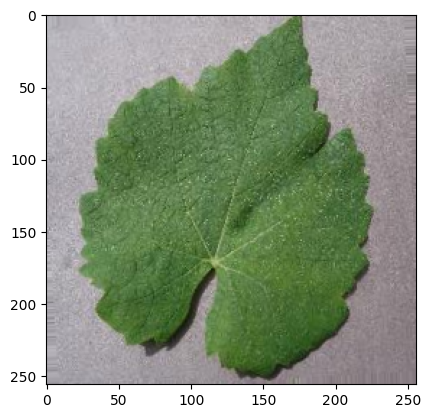

In [20]:
for image_batch, label_batch in test_generator:

    first_image = image_batch[0]
    first_label = int(label_batch[0])

    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

    break

# Function Predict

In [21]:
#now we write a function that takes model and an image as an input and tells us what is the predicted class 

def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #creates a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


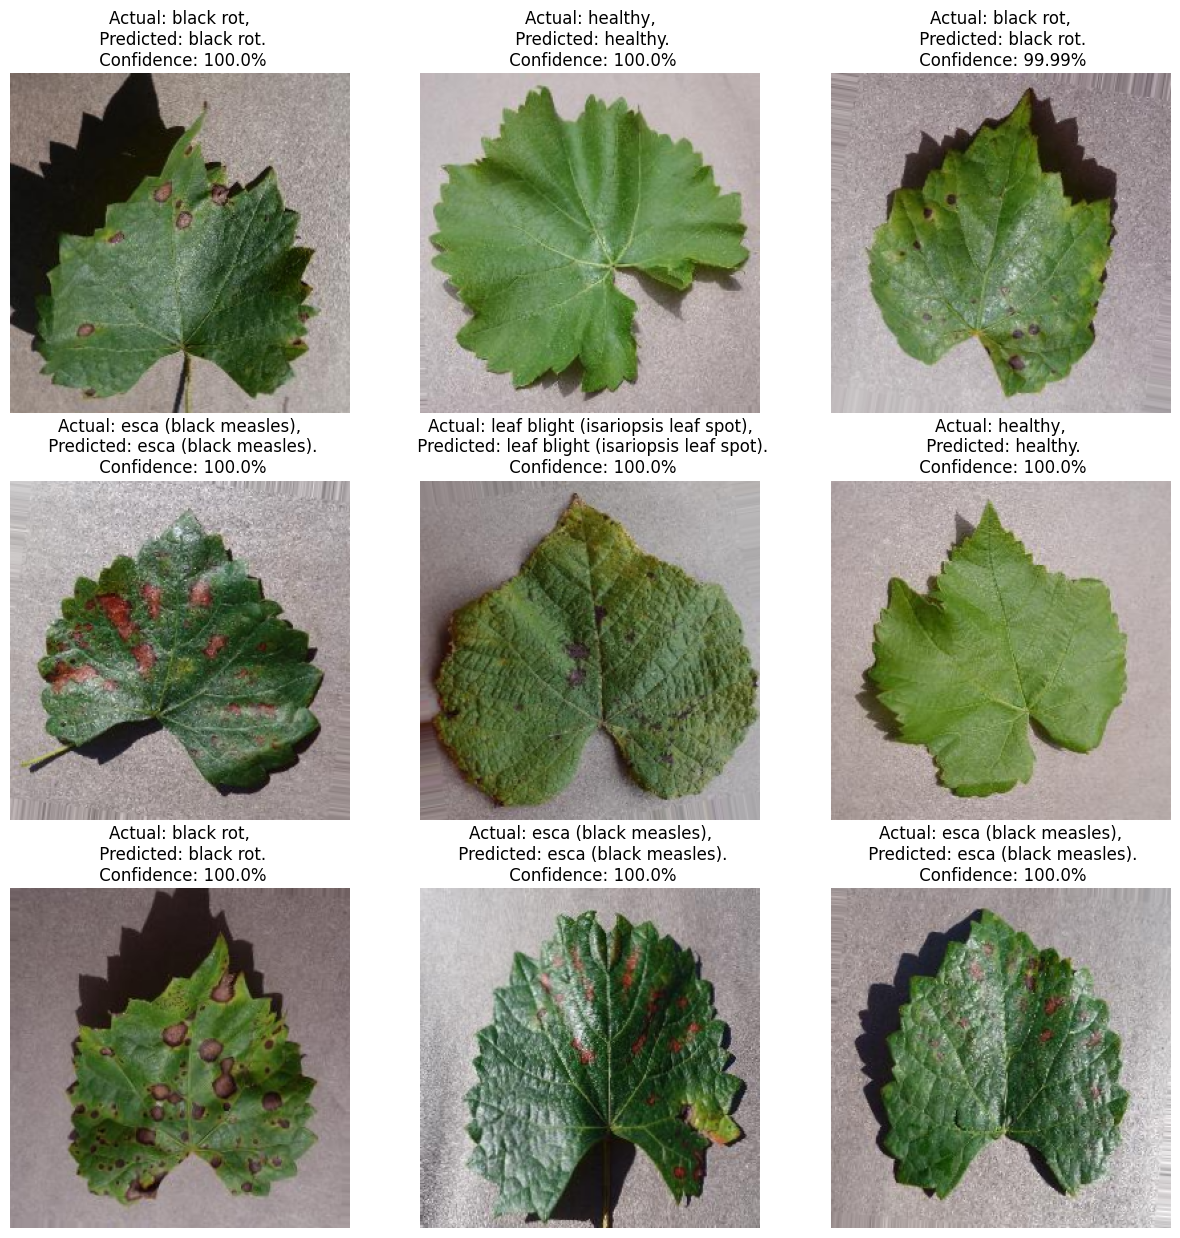

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1) 
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

    break

In [23]:
wandb.finish()

accuracy,▁▅▆▇▇▇▇▇████████████████████████████
batch/accuracy,▁▅▇▇▇▇▇▇████████████████████████▇███████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/accuracy,▁▅▆▇▇▇▇▇████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇▇▇█████████████████▇████████


In [28]:
model_version = 2
model.save(f"modelsdeepl/{model_version}")

INFO:tensorflow:Assets written to: modelsdeepl/2/assets


INFO:tensorflow:Assets written to: modelsdeepl/2/assets


In [26]:
model.save("modelsdeepl/grapes.h5")

/home/alvaro/anaconda3/envs/tf-tfx/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
